In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch.optim as optim

## Define the model

In [11]:
# --- Conv Block ---
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batchnorm=True, dropout_rate=0):
        super(ConvBlock, self).__init__()
        
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)]
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(inplace=True))

        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(inplace=True))

        self.conv = nn.Sequential(*layers)
        self.dropout = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else nn.Identity()

    def forward(self, x):
        return self.conv(x)
    

# --- Encoder Block ---
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x_conv = self.conv(x)
        x_pooled = self.pool(x_conv)
        return x_conv, x_pooled
    

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.up(x)


class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.wg = nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0)
        self.wx = nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0)
        self.psi = nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()



    def forward(self, g, x):
        g1 = self.wg(g)
        x1 = self.wx(x)
        psi = self.relu(g1 + x1)
        psi = self.sigmoid(self.psi(psi))
        return x * psi

    


# --- U-Net ---
class UNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=1, int_filters = 32):
        super(UNet, self).__init__()

        df = int_filters
        uf = int_filters

        self.e1 = EncoderBlock(in_channels, df)
        self.e2 = EncoderBlock(df, df * 2)
        self.e3 = EncoderBlock(df * 2, df * 4)
        self.e4 = EncoderBlock(df * 4, df * 8)

        self.bottleneck = ConvBlock(df * 8, df * 16)

        self.up4 = UpConv(df * 16, uf * 8)
        self.att4 = AttentionBlock(uf * 8, df * 8, uf * 8)
        self.conv4 = ConvBlock(uf * 8 + df * 8, uf * 8)

        self.up3 = UpConv(uf * 8, uf * 4)
        self.att3 = AttentionBlock(uf * 4, df * 4, uf * 4)
        self.conv3 = ConvBlock(uf * 4 + df * 4, uf * 4)

        self.up2 = UpConv(uf * 4, uf * 2)
        self.att2 = AttentionBlock(uf * 2, df * 2, uf * 2)
        self.conv2 = ConvBlock(uf * 2 + df * 2, uf * 2)

        self.up1 = UpConv(uf * 2, uf)
        self.att1 = AttentionBlock(uf, df, uf)
        self.conv1 = ConvBlock(uf + df, uf)

        self.final_conv = nn.Conv2d(uf, out_channels, kernel_size=1)

    def forward(self, x):
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.bottleneck(p4)

        u4 = self.up4(b)
        a4 = self.att4(u4, s4)
        u4 = torch.cat([u4, a4], dim=1)
        c4 = self.conv4(u4)

        u3 = self.up3(c4)
        a3 = self.att3(u3, s3)
        u3 = torch.cat([u3, a3], dim=1)
        c3 = self.conv3(u3)

        u2 = self.up2(c3)
        a2 = self.att2(u2, s2)
        u2 = torch.cat([u2, a2], dim=1)
        c2 = self.conv2(u2)

        u1 = self.up1(c2)
        a1 = self.att1(u1, s1)
        u1 = torch.cat([u1, a1], dim=1)
        c1 = self.conv1(u1)

        outputs = self.final_conv(c1)
        
        return outputs



## Load data

In [12]:
class ImageDataset(Dataset):
    def __init__(self, df_X, df_y):
        assert len(df_X) == len(df_y), "X and y must have same length"
        self.df_X = df_X
        self.df_y = df_y

    def __len__(self):
        return len(self.df_X)

    def __getitem__(self, idx):
        # --- Inputs ---
        s1 = self.df_X.iloc[idx]["s1"]   # numpy array (H, W)
        cs = self.df_X.iloc[idx]["cs"]   # numpy array (H, W)

        # Convert to tensor
        s1 = torch.tensor(s1, dtype=torch.float32)
        cs = torch.tensor(cs, dtype=torch.float32)

        # Stack into shape (2, H, W)
        X = torch.stack([s1, cs], dim=0)

        # --- Target ---
        y = self.df_y.iloc[idx]["adem"]     # numpy array (H, W) or (1, H, W)
        y = torch.tensor(y, dtype=torch.float32)

        if y.ndim == 2:
            y = y.unsqueeze(0)           # shape -> (1, H, W)

        return X, y

In [13]:
normalization = "raw"
dataDir = f"../data/interim/normalization-{normalization}/"
X_test = pd.read_pickle(f'{dataDir}/X_test.pkl')
y_test = pd.read_pickle(f'{dataDir}/y_test.pkl')
X_train = pd.read_pickle(f'{dataDir}/X_train.pkl')
y_train = pd.read_pickle(f'{dataDir}/y_train.pkl')
X_val = pd.read_pickle(f'{dataDir}/X_val.pkl')
y_val = pd.read_pickle(f'{dataDir}/y_val.pkl')

In [14]:
train_dataset = ImageDataset(X_train, y_train)
val_dataset   = ImageDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)

## Train model

In [15]:
model = UNet(in_channels=2, out_channels=1, int_filters=32)
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [16]:
num_epochs = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss) 

    # ---- Validation ----
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)

            preds = model(X)
            loss = criterion(preds, y)
            val_loss += loss.item() * X.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    

Epoch 1/20 | Train Loss: 648089.6162 | Val Loss: 628489.7683
Epoch 2/20 | Train Loss: 613361.0443 | Val Loss: 587341.0172
Epoch 3/20 | Train Loss: 561666.0650 | Val Loss: 527274.8723
Epoch 4/20 | Train Loss: 496780.8211 | Val Loss: 431338.1770
Epoch 5/20 | Train Loss: 422565.0873 | Val Loss: 371698.2174
Epoch 6/20 | Train Loss: 343019.0970 | Val Loss: 295026.9110
Epoch 7/20 | Train Loss: 264308.3519 | Val Loss: 208720.5664
Epoch 8/20 | Train Loss: 190595.3927 | Val Loss: 113657.4079
Epoch 9/20 | Train Loss: 128865.7784 | Val Loss: 87509.5880
Epoch 10/20 | Train Loss: 81663.3755 | Val Loss: 32241.8439
Epoch 11/20 | Train Loss: 50216.7854 | Val Loss: 20192.5414
Epoch 12/20 | Train Loss: 32733.0486 | Val Loss: 8993.8494
Epoch 13/20 | Train Loss: 23474.4197 | Val Loss: 8567.8919
Epoch 14/20 | Train Loss: 18383.1084 | Val Loss: 2010.8303
Epoch 15/20 | Train Loss: 15443.6060 | Val Loss: 10120.8537
Epoch 16/20 | Train Loss: 13855.2774 | Val Loss: 3589.9412
Epoch 17/20 | Train Loss: 11845.3025

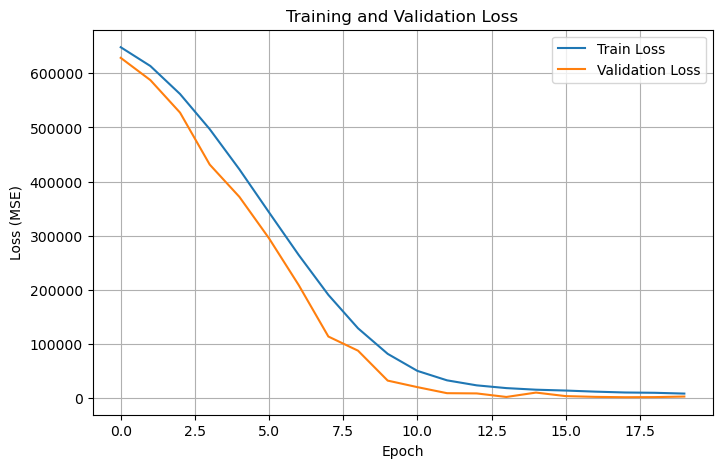

In [17]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)


In [18]:
import os
os.makedirs("../models/", exist_ok=True)
torch.save(model.state_dict(), f"../models/unet_normalization_{normalization}.pth")

(0.0, 40000.0)

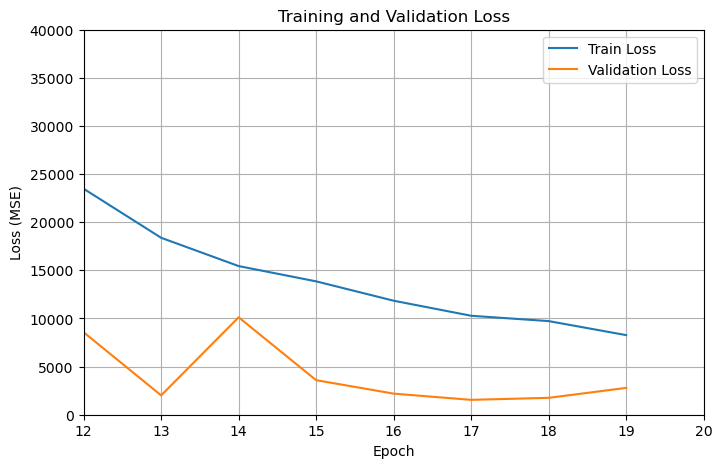

In [20]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.xlim(12,20)
plt.ylim(0,40000)